In [115]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'sans-serif',
        'weight' : 'light',
        'size'   : '12'}

plt.rc('font', **font)

In [116]:
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

In [117]:
def profile_normalization_brain(df_fname):
    data = pd.read_table(df_fname)
    df = data.T
    df.columns = df.iloc[0].values
    minkb = df.index.get_loc("-2.0Kb")
    pluskb = df.index.get_loc("2.0Kb")
    center = df.index.get_loc("Center")
    start_data=3
    end_average=1003

    av_wt=df["wt_1"][start_data:end_average].mean()
    av_wt2=df["wt_2"][start_data:end_average].mean()
    
    df_norm  = pd.DataFrame()
    df_norm['wt_1'] = df["wt_1"][start_data:].values/av_wt
    df_norm['wt_2'] = df["wt_2"][start_data:].values/av_wt2
 
    df_average = pd.DataFrame()
    df_err= pd.DataFrame()
    
    df_average['wt_av'] = df_norm[['wt_1', 'wt_2']].mean(axis=1)
    df_err['wt_err'] = df_norm[['wt_1', 'wt_2']].std(axis=1) / np.sqrt(2)

    
    return df_average, minkb, center, pluskb, df_err

In [118]:
def profile_normalization_heart(df_fname):
    data = pd.read_table(df_fname)
    df = data.T
    df.columns = df.iloc[0].values
    minkb = df.index.get_loc("-2.0Kb")
    pluskb = df.index.get_loc("2.0Kb")
    center = df.index.get_loc("Center")
    start_data=3
    end_average=1003

    av_wt=df["WT"][start_data:end_average].mean()
    av_wt2=df["WT"][start_data:end_average].mean()

    df_average = pd.DataFrame()

    # there is actually no averaging here, since the two libraries we had were
    # very different in size (~1 million vs ~45 million reads) we decided to merge
    # the two, thus we have just one curve. I leave that as "average" anyway
    df_average["wt_av"] = df["WT"][start_data:].values/av_wt 

    return df_average, minkb, center, pluskb

In [119]:
prof_brain = profile_normalization_brain("5fC_cent_regions_invitro_brain.dat")
prof_brain_rand = profile_normalization_brain("no5fC_rand_invitro_brain.dat")
prof_heart = profile_normalization_heart("5fC_cent_regions_invitro_heart.dat")
prof_heart_rand = profile_normalization_heart("no5fC_rand_invitro_heart.dat")

In [130]:
def plot_profiles_cg(pb, pb_rand, ph, ph_rand, h_5fC_label=4, fname="reconstitution_heart.pdf"):
    num_plots = 2
    columns = 2
    f, axis = plt.subplots(num_plots, columns, figsize=(cm2inch(25,10)), 
                           sharex='col', sharey='row',
                           gridspec_kw = {'height_ratios':[2, 1]},
                           dpi=120)
    f.subplots_adjust(hspace=0.)
    f.subplots_adjust(wspace=0)

    x_tick_loc = [pb[1]-2, pb[2]-2, pb[3]-2]
    y_ax_label = "MNase signal (norm. RPKM)"
    x_tick_labels = ["-2.0", "Center", "2.0"]
    c = 0
    for x, p, n in zip(axis[0], [pb[0][:-1], pb_rand[0][:-1]], ["5fC", "non5fC"]):
        c += 1
        
        x.plot(p["wt_av"], label='Untreated')

        if c == 1:
            x.set_ylabel("MNase signal\n(norm. RPKM)")


        x.set_xticks(x_tick_loc)
        x.set_xticklabels(x_tick_labels)
        x.get_yaxis().set_label_coords(-0.15,0.5)
        x.text(0, h_5fC_label, n, size=14, verticalalignment="bottom")
    c=0        
    for x, p, n  in zip(axis[1], [ph, ph_rand], ["5fC", "non5fC"]):
        c += 1
        # The GC content was computed with 0.5 as background (expecting 50%)
        # but in mm9 it is actually 0.42, hence the +0.08 to correct that
        x.plot(p["GC"]+0.08, label="GC contents", color="green")
        if c == 1:
            x.set_ylabel("GC\nenrichment")
        #x.legend(frameon=False)
        x.set_xticks(x_tick_loc)
        x.set_xticklabels(x_tick_labels)
        x.get_yaxis().set_label_coords(-0.15,0.5)
        x.text(0, 0.055, n, size=14, verticalalignment="bottom")

        
    f.savefig(fname, bbox_inches='tight')

In [131]:
def plot_profiles_cg_heart(pb, pb_rand, ph, ph_rand, h_5fC_label=4, fname="reconstitution_heart.pdf"):
    num_plots = 2
    columns = 2
    f, axis = plt.subplots(num_plots, columns, figsize=(cm2inch(25,10)), 
                           sharex='col', sharey='row',
                           gridspec_kw = {'height_ratios':[2, 1]},
                           dpi=120)
    f.subplots_adjust(hspace=0.)
    f.subplots_adjust(wspace=0)


    x_tick_loc = [pb[1]-2, pb[2]-2, pb[3]-2]
    y_ax_label = "MNase signal (norm. RPKM)"
    x_tick_labels = ["-2.0", "Center", "2.0"]
    c = 0
    for x, p, err, n in zip(axis[0], [pb[0][:-1], pb_rand[0][:-1]], [pb[4][:-1], pb_rand[4][:-1]], ["5fC", "non5fC"]):
        c += 1

        ymin = p['wt_av'] - err['wt_err']
        ymax = p['wt_av'] + err['wt_err']
        x.plot(p['wt_av'])
        x.fill_between(np.array([x for x in range(len(p['wt_av']))]),  
                       ymax, ymin, alpha=0.5)

        if c == 1:
            x.set_ylabel("MNase signal\n(norm. RPKM)")

        x.set_xticks(x_tick_loc)
        x.set_xticklabels(x_tick_labels)
        x.get_yaxis().set_label_coords(-0.15,0.5)
        x.text(0, h_5fC_label, n, size=14, verticalalignment="bottom")
    c=0        
    for x, p, n  in zip(axis[1], [ph, ph_rand], ["5fC", "non5fC"]):
        c += 1
        # The GC content was computed with 0.5 as background (expecting 50%)
        # but in mm9 it is actually 0.42, hence the +0.08 to correct that
        x.plot(p["GC"]+0.08, label="GC contents", color="green")
        if c == 1:
            x.set_ylabel("GC\nenrichment")

        x.set_xticks(x_tick_loc)
        x.set_xticklabels(x_tick_labels)
        x.get_yaxis().set_label_coords(-0.15,0.5)
        x.text(0, 0.055, n, size=14, verticalalignment="bottom")

        
    f.savefig(fname, bbox_inches='tight')

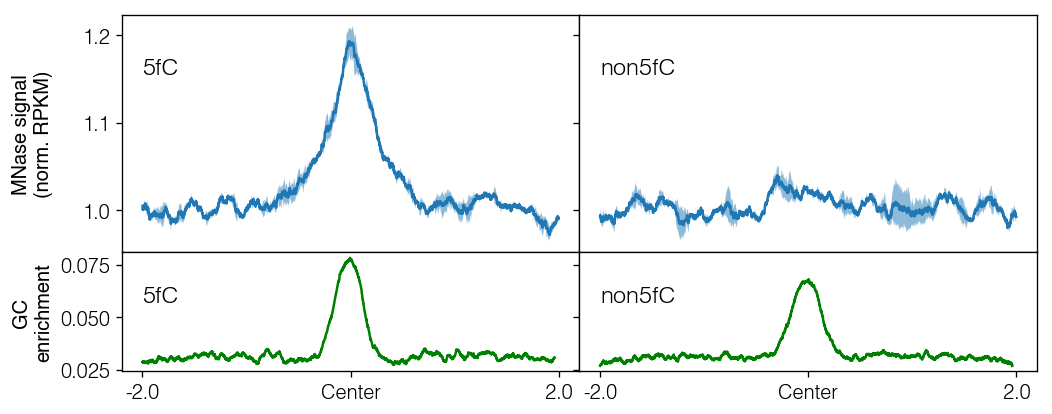

In [132]:
cg_brain = pd.read_csv("ref_brain.txt", header=None, names =["GC"])
cg_brain_rand = pd.read_csv("rand_brain.txt", header=None, names=["GC"])
plot_profiles_cg_heart(prof_brain, prof_brain_rand, cg_brain, cg_brain_rand, h_5fC_label=1.15, fname="reconstitution_brain.pdf")

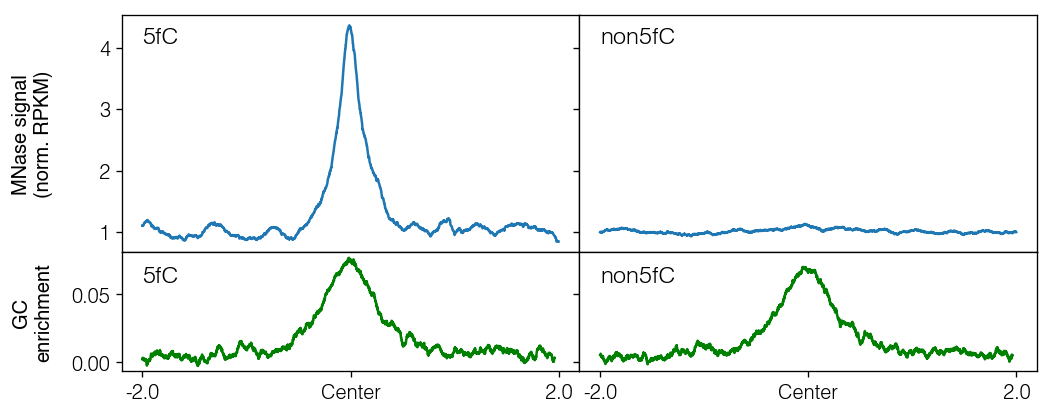

In [133]:
cg_heart = pd.read_csv("ref_heart.txt", header=None, names =["GC"])
cg_heart_rand = pd.read_csv("rand_heart.txt", header=None, names=["GC"])
plot_profiles_cg(prof_heart, prof_heart_rand, cg_heart, cg_heart_rand, fname="reconstitution_heart.pdf")